Epoch 1/50
3/3 [==============================] - 6s 493ms/step - loss: 0.6805 - accuracy: 0.6944 - val_loss: 0.6538 - val_accuracy: 0.8750
Epoch 2/50
3/3 [==============================] - 0s 24ms/step - loss: 0.6279 - accuracy: 0.9444 - val_loss: 0.6062 - val_accuracy: 0.8750
Epoch 3/50
3/3 [==============================] - 0s 21ms/step - loss: 0.5761 - accuracy: 0.9444 - val_loss: 0.5526 - val_accuracy: 0.8750
Epoch 4/50
3/3 [==============================] - 0s 20ms/step - loss: 0.5144 - accuracy: 0.9444 - val_loss: 0.4912 - val_accuracy: 0.8750
Epoch 5/50
3/3 [==============================] - 0s 19ms/step - loss: 0.4323 - accuracy: 0.9444 - val_loss: 0.4267 - val_accuracy: 0.8750
Epoch 6/50
3/3 [==============================] - 0s 19ms/step - loss: 0.3561 - accuracy: 0.9444 - val_loss: 0.3790 - val_accuracy: 0.8750
Epoch 7/50
3/3 [==============================] - 0s 19ms/step - loss: 0.2840 - accuracy: 0.9444 - val_loss: 0.3758 - val_accuracy: 0.8750
Epoch 8/50
3/3 [==========

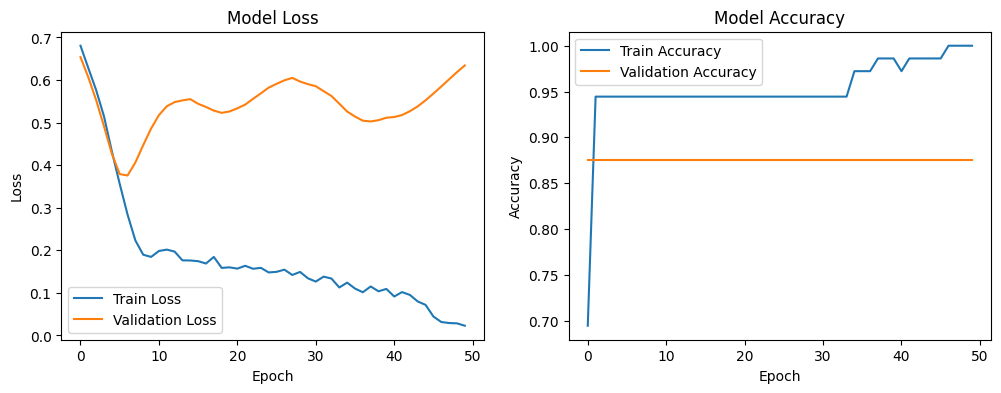

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Parameters
sequence_length = 10  # Define the sequence length
epochs = 50
batch_size = 32

# Load the data
data = pd.read_csv('your_file.csv')  # Replace 'data.csv' with the path to your CSV file

# Ensure that the 'anomaly' column is present in the dataset
if 'Anomaly' not in data.columns:
    raise ValueError("The dataset must contain an 'anomaly' column with labels (0 for normal, 1 for anomaly)")

# Drop the 'Reason for change' column
data = data.drop(columns=['Reason for change'])

# Preprocessing
# One-Hot Encode the 'User' and 'Activity Description' columns
data_encoded = pd.get_dummies(data, columns=['User', 'Activity Description'], drop_first=True)

# Separate features and labels
feature_columns = data_encoded.columns.difference(['Anomaly', 'Date', 'Time'])  # Exclude 'anomaly', 'Date', and 'Time'
labels = data_encoded['Anomaly'].values  # The labels (0 or 1)

# Step 1: Normalize the features (exclude 'Date' and 'Time')
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_encoded[feature_columns])

# Step 2: Create sequences and labels for each sequence
def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i: i + sequence_length])
        sequence_labels.append(labels[i + sequence_length - 1])  # Label for the sequence is the last item
    return np.array(sequences), np.array(sequence_labels)

X, y = create_sequences(data_scaled, labels, sequence_length)

# Step 3: Train-test split
# Using the same data for training and testing in this case (not recommended in real applications)
X_train, y_train = X, y

# Step 4: Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)
model.save('anomaly_detection_model.h5')  # Save the model to a file
print("Model saved successfully!")

# Step 6: Evaluate the model on the same dataset
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Loss: {loss:.4f}, Training Accuracy: {accuracy:.4f}')

# Step 7: Make predictions on the same data
y_pred = (model.predict(X_train) > 0.5).astype(int)  # Threshold at 0.5

# Step 8: Performance metrics
print("Classification Report:")
print(classification_report(y_train, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))

# Optional: Visualize the loss and accuracy over epochs
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
